In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix

# 0. Load datasets

In [2]:
datasets_path = lambda  file_name: f'/Users/stijnvanleeuwen/Desktop/codes/EUR/Ass2/datasets/{file_name}.parquet'

baskets = pd.read_parquet(datasets_path('baskets')).astype({'week':'uint8', 'customer':'category','product':'category', 'price':'uint16'}) 
coupons = pd.read_parquet(datasets_path('coupons')).astype({'week':'uint8', 'customer':'category','product':'category', 'discount':'uint8'})
prediction_index = pd.read_parquet(datasets_path('prediction_index')).astype({'week':'uint8', 'customer':'category','product':'category'}) 

# 1. Create base dataframe 

In [ ]:
weeks = range(80,89+1)
customers = range(20)
products = range(250)

n_weeks, n_customers, n_products = len(weeks), len(customers), len(products)

base = pd.DataFrame()

base['week'] =     np.array([[x] * n_products * n_customers for x in weeks]).flatten()
base['customer'] = np.array([[x] * n_products * n_weeks for x in customers]).flatten()
base['product'] =  np.array([[x] * n_weeks * n_customers for x in products]).flatten()

base = pd.merge(base, baskets, on=['week', 'customer','product'], how='left')

base['price'] = base['price'].fillna(0).astype('uint16')
base['bought'] = (base['price']!=0).astype(int)

Error: Session cannot generate requests

In [32]:
#One-hot encoding product and dummy iDs as they should not be seen as numerical but as categorical 
base2 = pd.get_dummies(base)

In [35]:
list(base2.columns)

['week',
 'price',
 'bought',
 'customer_0',
 'customer_1',
 'customer_2',
 'customer_3',
 'customer_4',
 'customer_5',
 'customer_6',
 'customer_7',
 'customer_8',
 'customer_9',
 'customer_10',
 'customer_11',
 'customer_12',
 'customer_13',
 'customer_14',
 'customer_15',
 'customer_16',
 'customer_17',
 'customer_18',
 'customer_19',
 'customer_20',
 'customer_21',
 'customer_22',
 'customer_23',
 'customer_24',
 'customer_25',
 'customer_26',
 'customer_27',
 'customer_28',
 'customer_29',
 'customer_30',
 'customer_31',
 'customer_32',
 'customer_33',
 'customer_34',
 'customer_35',
 'customer_36',
 'customer_37',
 'customer_38',
 'customer_39',
 'customer_40',
 'customer_41',
 'customer_42',
 'customer_43',
 'customer_44',
 'customer_45',
 'customer_46',
 'customer_47',
 'customer_48',
 'customer_49',
 'customer_50',
 'customer_51',
 'customer_52',
 'customer_53',
 'customer_54',
 'customer_55',
 'customer_56',
 'customer_57',
 'customer_58',
 'customer_59',
 'customer_60',
 'cu

# 2. Split into train & test

In [40]:
train = base2[base2['week']!=89]
test =  base2[base2['week']==89]

x_train, x_test = train.drop(['price','bought'],axis=1), test.drop(['price','bought'],axis=1)
y_train, y_test = train['bought'], test['bought']

In [ ]:
x_test

Error: Session cannot generate requests

# 3. Random Forest Classification

In [37]:
# a. Train model
model = DecisionTreeClassifier(max_leaf_nodes=100, random_state=42)
model.fit(x_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=100, random_state=42)

<IPython.core.display.Javascript object>

[Text(2257.7658582089553, 3193.65, 'customer <= 401.5\ngini = 0.057\nsamples = 4500000\nvalue = [4367500, 132500]'),
 Text(1051.455223880597, 3057.75, 'customer <= 398.5\ngini = 0.086\nsamples = 1005000\nvalue = [960000, 45000]'),
 Text(770.3731343283582, 2921.85, 'customer <= 306.5\ngini = 0.077\nsamples = 997500\nvalue = [957500, 40000]'),
 Text(458.05970149253733, 2785.95, 'customer <= 22.5\ngini = 0.057\nsamples = 767500\nvalue = [745000, 22500]'),
 Text(291.4925373134328, 2650.0499999999997, 'customer <= 21.5\ngini = 0.159\nsamples = 57500\nvalue = [52500, 5000]'),
 Text(208.2089552238806, 2514.1499999999996, 'customer <= 10.5\ngini = 0.087\nsamples = 55000\nvalue = [52500, 2500]'),
 Text(124.92537313432837, 2378.25, 'gini = 0.0\nsamples = 27500\nvalue = [27500, 0]'),
 Text(291.4925373134328, 2378.25, 'customer <= 11.5\ngini = 0.165\nsamples = 27500\nvalue = [25000, 2500]'),
 Text(208.2089552238806, 2242.35, 'gini = 0.0\nsamples = 2500\nvalue = [0, 2500]'),
 Text(374.7761194029851

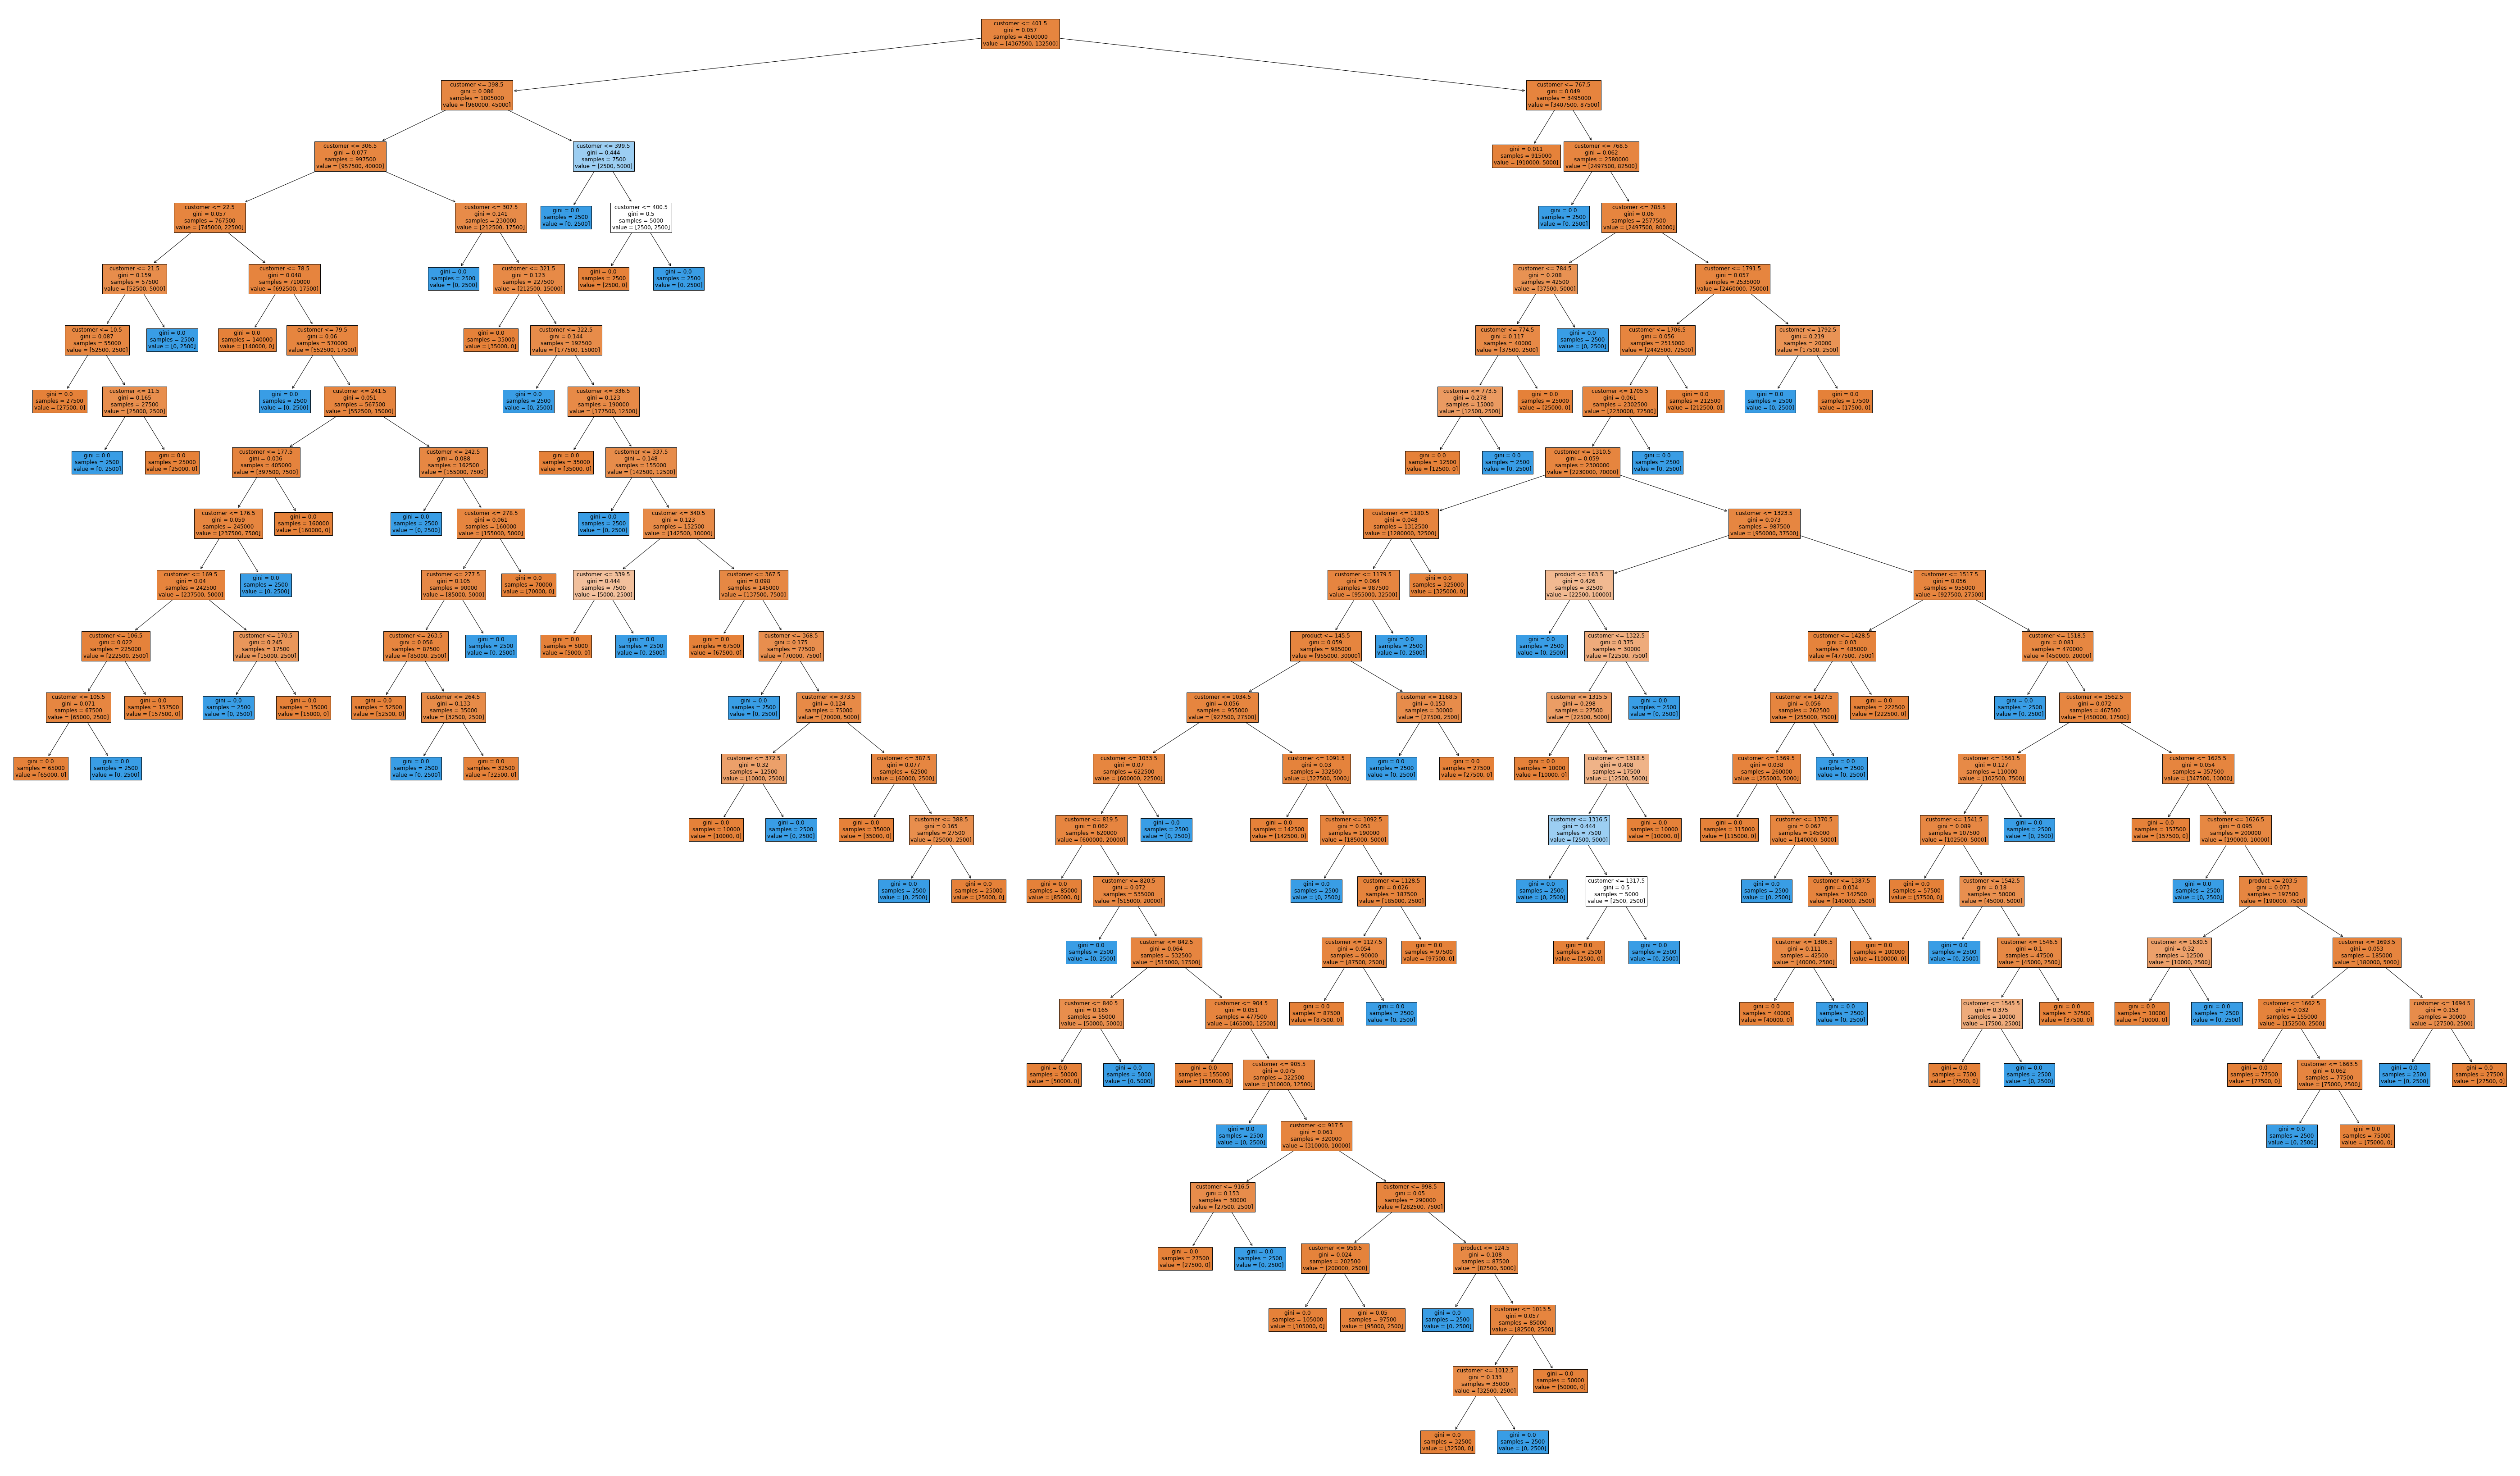

In [38]:
plt.figure(figsize=(100,60))
tree.plot_tree(model,fontsize=12, filled=1, feature_names=list(x_train.columns))

In [27]:
# b. Predict y on test
y_pred = model.predict(x_test)
y_pred.mean()

0.0

In [16]:
# c. Get confusion matrix
print(classification_report(y_test, y_pred))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.94      1.00      0.97    472500
           1       0.00      0.00      0.00     27500

    accuracy                           0.94    500000
   macro avg       0.47      0.50      0.49    500000
weighted avg       0.89      0.94      0.92    500000



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
y_test.mean()

0.055

In [17]:
metrics.precision_score(y_test,y_pred)

<IPython.core.display.Javascript object>

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0